# Deskový model

## Kirchhoffova teorie ohybu tenkých desek

Podobně jako u nosníků i zde tato teorie ohybu vede na rovnici čtvrtého řádu, která vynucuje prvky vyšších řádů se spojitými prvními derivacemi. Tato teorie zde prozatím nebude řešena.

## Mindlin-Reissner teorie ohybu

[TODO: Doplnit diferenciální rovnice a slabou formu]

Implementace není tolik odlišná od nosníkové teorie. Je nutné pracovat s 2D sítí a s vektorovými prostory funkcí, jinak implementace nepřináší novoty. Nejprve je vhodné opět importovat všechny nutné knihovny a definovat všechny fyzikální konstanty:

In [ ]:
import dolfinx as dfx
from mpi4py import MPI
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
import matplotlib.pyplot as plt
import dolfinx.fem.petsc

# Geometrické parametry
l_x, l_y, l_z = 1.0, 1.0, 0.02  # Šířka, Délka, Tloušťka

# Dělení sítě v obou směrech
nx, ny = 10, 10

# Stupně úlohy
deg = 1  # Stupeň polynomů aproximující hledané funkce
deg_shear = 0  # Stupeň integrace smyku, volíme 0 pro selektivní integraci

# Materiálové parametry
E, nu = 72e9, 0.22  # Youngův modul pružnosti, Poissonovo číslo
mu, lmbda = 0.5 * E / (1 + nu), E * nu / (1 + nu) / (1 - 2 * nu)  # Lamého koeficienty
lmbda = 2 * mu * lmbda / (lmbda + 2 * mu)  # Plane-stress korekce

Opět vytvoříme výpočetní síť. Pro účely této úlohy se spokojíme s obyčejnou čtvercovou deskou podepřenou po okrajích. Pro efektivnější řešení ji není nutné modelovat celou, pouze čtvrtinu.

In [ ]:
mesh = dfx.mesh.create_rectangle(MPI.COMM_WORLD, [[0.0, 0.0], [0.5*l_x, 0.5*l_y]], [nx, ny])
tdim = mesh.topology.dim  # Dimenze prvků sítě
fdim = tdim - 1  # Dimenze hran sítě

Následuje vytvoření prostoru funkcí. Neznámý je příčný průhyb $w(x,y)$, který žije v prostoru skalárních funkcí, zatímco pole podélných posunů ${\boldsymbol u}(x,y)$ a pootočení průřezu ${\boldsymbol \varphi}(x,y)$ jsou vektorové veličiny. Vytvoříme proto příslušný smíšený prostor

In [ ]:
p1_element = ufl.FiniteElement("P", mesh.ufl_cell(), deg)
v1_element = ufl.VectorElement("P", mesh.ufl_cell(), deg)
v = dfx.fem.functionspace(mesh, ufl.MixedElement([p1_element, v1_element, v1_element]))
v0 = dfx.fem.FunctionSpace(mesh, ("Lagrange", 1))  # Pomocný prostor pro práci se sítí

Následně vytvoříme Dirichletovy okrajové podmínky s opětovným využitím pomocné funkce <code>dirichletbc_subspace</code>. Zde je vhodné připomenout, že příkazem <code>v.sub(1)</code> přistupujeme k druhému podprostoru, tedy prostoru pro ${\boldsymbol u}=(u_x,u_y)$. Tenprve příkazem <code>v.sub(1).sub(0)</code> přistupujeme k první komponentě vektorového prostoru - jedná se tedy o prostor, kde žije komponenta $u_x$. V následujícím příkladu vynucujeme po okraji prosté podepření a následně podmínky symetrie.

In [ ]:
def left(x):
    return np.isclose(x[0], 0.0)

def right(x):
    return np.isclose(x[0], 0.5*l_x)

def bottom(x):
    return np.isclose(x[1], 0.0)

def top(x):
    return np.isclose(x[1], 0.5*l_y)

def dirichletbc_subspace(subspace, location, value_i):
    v_i, submap_i = subspace.collapse()
    dofs = dfx.fem.locate_dofs_geometrical((subspace, v_i), location)
    return dfx.fem.dirichletbc(ScalarType(value_i), dofs[0], subspace)

bc1 = dirichletbc_subspace(v.sub(2).sub(1), left, 0.0)
bc2 = dirichletbc_subspace(v.sub(2).sub(0), bottom, 0.0)
bc3 = dirichletbc_subspace(v.sub(1).sub(0), left, 0.0)
bc4 = dirichletbc_subspace(v.sub(1).sub(1), bottom, 0.0)
bc5 = dirichletbc_subspace(v.sub(0), right, 0.0)
bc6 = dirichletbc_subspace(v.sub(0), top, 0.0)
bc = [bc1, bc2, bc3, bc4, bc5, bc6]

Nyní můžeme pomocí knihovny <code>ufl</code> definovat řešenou slabou formu. Smykové zamykání je řešeno dále, zatím je tento fenomén ignorován.

In [ ]:
# Elastic strain tensor
def eps(v):
    return ufl.sym(ufl.grad(v))

#dx_shear = ufl.Measure("dx", metadata={"quadrature_degree": deg_shear})
dx_shear = ufl.dx

k = 5.0 / 6.0
S = ufl.as_tensor([[0.0, 1.0], [-1.0, 0.0]])

w_tr, u_tr, phi_tr = ufl.TrialFunctions(v)
w_test, u_test, phi_test = ufl.TestFunctions(v)

A_form = 0.0

D1 = (E * l_z ** 3) / (12.0 * (1.0 - nu ** 2))
D2 = (E * k * l_z) / (2.0 * (1.0 + nu))
D3 = (E * l_z) / (1.0 - nu ** 2)
kappa_tr, kappa_test = eps(S * phi_tr), eps(S * phi_test)
du_tr, du_test = eps(u_tr), eps(u_test)
A_form += ufl.inner(D1 * (nu * ufl.div(S * phi_tr) * ufl.Identity(2) + (1.0 - nu) * kappa_tr), kappa_test) * ufl.dx
A_form += ufl.inner(D3 * (nu * ufl.div(u_tr) * ufl.Identity(2) + (1.0 - nu) * du_tr), du_test) * ufl.dx
A_form += D2 * ufl.inner(ufl.grad(w_tr) + S * phi_tr, ufl.grad(w_test) + S * phi_test) * dx_shear
A_form += dfx.fem.Constant(mesh, 1.0)*w_test*ufl.dx

A_left = ufl.lhs(A_form)
A_right = ufl.rhs(A_form)

Nyní už zbývá jen zavolat řešič a nechat úlohu vyřešit:

In [ ]:
x_sol = dfx.fem.Function(v)

problem = dfx.fem.petsc.LinearProblem(
    A_left, A_right, u=x_sol, bcs=bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()

w_sol = x_sol.sub(0).collapse()

Můžeme si nechat vypsat i maximální uzlový průhyb následovně.

In [ ]:
print("Maximální uzlový průhyb: {}".format(np.amin(w_sol.x.array)))
print("Přesné řešení pro tenkou desku: {}".format(0.004062353*12*(1-nu**2)/E/l_z**3))

Rozdíl ve spočteném průhybu a teoretickou hodnotou se může zdát veliký, ale přeci jen se jedná o hodnotu pro tenkou desku a otázka je, zda tloušťka 0.02 m je už tenká deska. Nicméně při změně parametrů se řešení začíná chovat podivně. Předchozí kód byl představen zejména z didaktických důvodů, jako ukázka jak se s implementací takového fyzikálního systému vypořádat. Relativně lehce lze ale ukázat, že takto implementovaný deskový model je nepoužitelný. Zkusme např. úlohu vyřešit znovu, ale s nižší tloušťkou desky. V tu chvíli očekáváme, že numerické řešení se bude přibližovat teoretické hodnotě pro tenkou desku. Avšak dostáváme:

In [ ]:
l_z = 0.0002

A_form = 0.0

D1 = (E * l_z ** 3) / (12.0 * (1.0 - nu ** 2))
D2 = (E * k * l_z) / (2.0 * (1.0 + nu))
D3 = (E * l_z) / (1.0 - nu ** 2)
kappa_tr, kappa_test = eps(S * phi_tr), eps(S * phi_test)
du_tr, du_test = eps(u_tr), eps(u_test)
A_form += ufl.inner(D1 * (nu * ufl.div(S * phi_tr) * ufl.Identity(2) + (1.0 - nu) * kappa_tr), kappa_test) * ufl.dx
A_form += ufl.inner(D3 * (nu * ufl.div(u_tr) * ufl.Identity(2) + (1.0 - nu) * du_tr), du_test) * ufl.dx
A_form += D2 * ufl.inner(ufl.grad(w_tr) + S * phi_tr, ufl.grad(w_test) + S * phi_test) * dx_shear
A_form += dfx.fem.Constant(mesh, 1.0)*w_test*ufl.dx

A_left = ufl.lhs(A_form)
A_right = ufl.rhs(A_form)

x_sol = dfx.fem.Function(v)

problem = dfx.fem.petsc.LinearProblem(
    A_left, A_right, u=x_sol, bcs=bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()

w_sol = x_sol.sub(0).collapse()

print("Maximální uzlový průhyb: {}".format(np.amin(w_sol.x.array)))
print("Přesné řešení pro tenkou desku: {}".format(0.004062353*12*(1-nu**2)/E/l_z**3))

Při snížení tloušťky desky došlo k tomu, že teoretická hodnota a numerický výpočet se od sebe vzdálily. Jedná se o efekt tzv. smykového zamykání, který hnedle vyšetšíme v další části.

## Smykové zamykání

Opět nejprve vytvoříme pomocnou funkci <code>plate_solver</code>, která má celou řadu parametrů. Jmenovitě <code>h_i</code> pro tloušťku desky, <code>E, nu</code> pro materiálové parametry, <code>deg</code> pro stupeň polynomu aproximace řešení, <code>red_int</code> pro nastavení redukované integrace, <code>cell_type</code> pro přepínání mezi čtvercovými a trojúhelníkovými prvky, <code>el_type</code> pro volbu typu prvky, <code>fixed</code> pro přepínání mezi prostě podepřenou deskou a vetknutou deskou a nakonec <code>nel</code> pro volbu počtu prvků. Ještě uvádíme, že <code>red_int</code> nabývá tří hodnot a to <code>none</code> pro plnou integraci, <code>all</code> pro redukovanou integraci všech členů a <code>shear</code> pro redukovanou integraci pro smykové členy.

In [1]:
import dolfinx as dfx
from mpi4py import MPI
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
import matplotlib.pyplot as plt
import dolfinx.fem.petsc
import petsc4py as pt


def plate_solver(h_i, E, nu, deg, red_int, cell_type, el_type, fixed, nel):
    # Parametry
    l_x, l_y, l_z = 1.0, 1.0, h_i
    mu, lmbda = 0.5 * E / (1 + nu), E * nu / (1 + nu) / (1 - 2 * nu)
    lmbda = 2 * mu * lmbda / (lmbda + 2 * mu)

    mesh = dfx.mesh.create_rectangle(MPI.COMM_WORLD, [[0.0, 0.0], [0.5*l_x, 0.5*l_y]], [nel, nel], cell_type)
    tdim = mesh.topology.dim
    fdim = tdim - 1

    p1_element = ufl.FiniteElement(el_type, mesh.ufl_cell(), deg)
    v1_element = ufl.VectorElement(el_type, mesh.ufl_cell(), deg)
    v = dfx.fem.functionspace(mesh, ufl.MixedElement([p1_element, v1_element]))

    def left(x):
        return np.isclose(x[0], 0.0)

    def x_middle(x):
        return np.isclose(x[0], 0.5*l_x)

    def bottom(x):
        return np.isclose(x[1], 0.0)

    def y_middle(x):
        return np.isclose(x[1], 0.5*l_y)

    def dirichletbc_subspace(subspace, location, value_i):
        v_i, submap_i = subspace.collapse()
        edges = dfx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, location)
        boundary_dofs = dfx.fem.locate_dofs_topological((subspace, v_i), mesh.topology.dim - 1, edges)
        zero_scalar = dfx.fem.Function(v_i)
        return dfx.fem.dirichletbc(zero_scalar, boundary_dofs, subspace)

    bc1 = dirichletbc_subspace(v.sub(1).sub(1), x_middle, 0.0)
    bc2 = dirichletbc_subspace(v.sub(1).sub(0), y_middle, 0.0)
    bc3 = dirichletbc_subspace(v.sub(0), left, 0.0)
    bc4 = dirichletbc_subspace(v.sub(0), bottom, 0.0)
    bc5 = dirichletbc_subspace(v.sub(1).sub(1), left, 0.0)
    bc6 = dirichletbc_subspace(v.sub(1).sub(0), bottom, 0.0)

    if fixed:
        bc = [bc1, bc2, bc3, bc4, bc5, bc6]
    else:
        bc = [bc1, bc2, bc3, bc4]

    # Elastic strain tensor
    def eps(v):
        return ufl.sym(ufl.grad(v))

    if red_int == "all":
        dx = ufl.Measure("dx", metadata={"quadrature_degree": 2*deg - 2})
        dx_shear = dx
    elif red_int == "shear":
        dx = ufl.dx
        dx_shear = ufl.Measure("dx", metadata={"quadrature_degree": 2*deg - 2})
    else:
        dx = ufl.dx
        dx_shear = dx

    k = 5.0 / 6.0
    S = ufl.as_tensor([[0.0, 1.0], [-1.0, 0.0]])

    w_tr, phi_tr = ufl.TrialFunctions(v)
    w_test, phi_test = ufl.TestFunctions(v)

    A_form = 0.0

    D1 = (E * l_z ** 3) / (12.0 * (1.0 - nu ** 2))
    D2 = (E * k * l_z) / (2.0 * (1.0 + nu))
    kappa_tr, kappa_test = eps(S * phi_tr), eps(S * phi_test)
    A_form += ufl.inner(D1 * (nu * ufl.div(S * phi_tr) * ufl.Identity(2) + (1.0 - nu) * kappa_tr), kappa_test) * dx
    A_form += D2 * ufl.inner(ufl.grad(w_tr) + S * phi_tr, ufl.grad(w_test) + S * phi_test) * dx_shear
    A_form += dfx.fem.Constant(mesh, -h_i**3) * w_test * dx

    A_left = ufl.lhs(A_form)
    A_right = ufl.rhs(A_form)

    x_sol = dfx.fem.Function(v)

    problem = dfx.fem.petsc.LinearProblem(
        #A_left, A_right, u=x_sol, bcs=bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
        A_left, A_right, u=x_sol, bcs=bc, petsc_options={"ksp_type": "cg", "pc_type": "lu"}
    )
    problem.solve()
    w_sol = x_sol.sub(0).collapse()

    return np.amax(w_sol.x.array)

Nyní můžeme vyzkoušet pustit kód pro trojúhelníkové prvky prvního, druhého a třetího řádu pro oba způsoby podepření, dostáváme:

In [ ]:
Ei, nui = 1.0, 0.2

ts = np.logspace(-4, -1, num=20)
ws_tr_ss_p1 = [plate_solver(tsi, Ei, nui, 1, "", dolfinx.mesh.CellType.triangle, "P", False, 10) for tsi in ts]
ws_tr_ss_p2 = [plate_solver(tsi, Ei, nui, 2, "", dolfinx.mesh.CellType.triangle, "P", False, 10) for tsi in ts]
ws_tr_ss_p3 = [plate_solver(tsi, Ei, nui, 3, "", dolfinx.mesh.CellType.triangle, "P", False, 10) for tsi in ts]

ws_tr_ff_p1 = [plate_solver(tsi, Ei, nui, 1, "", dolfinx.mesh.CellType.triangle, "P", True, 10) for tsi in ts]
ws_tr_ff_p2 = [plate_solver(tsi, Ei, nui, 2, "", dolfinx.mesh.CellType.triangle, "P", True, 10) for tsi in ts]
ws_tr_ff_p3 = [plate_solver(tsi, Ei, nui, 3, "", dolfinx.mesh.CellType.triangle, "P", True, 10) for tsi in ts]

plt.title("Prostě podepřená deska")
plt.plot(1 / ts, ws_tr_ss_p1, color="r", label="P1")
plt.plot(1 / ts, ws_tr_ss_p2, color="g", label="P2")
plt.plot(1 / ts, ws_tr_ss_p3, color="b", label="P3")
plt.axhline(y=0.004062353*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.03, 0.05)
plt.legend()
plt.show()

plt.title("Po obvodě vetknutá deska")
plt.plot(1 / ts, ws_tr_ff_p1, color="r", label="P1")
plt.plot(1 / ts, ws_tr_ff_p2, color="g", label="P2")
plt.plot(1 / ts, ws_tr_ff_p3, color="b", label="P3")
plt.axhline(y=0.001265319*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.01, 0.0175)
plt.legend()
plt.show()

Je zde vidět tragická odezva. U všechn prvků je vidět postupně sílící efekt smykového zamykání. Pro snižující se tloušťku desky očekáváme přibližování se k řešení pro tenkou desku (čárkovaná čára), nicméně nic takového nepozorujeme. I pro jiné typy prvků pozorujeme takto siný efekt zamykání, např. pro obdélníkové serendipity prvky dostáváme:

In [ ]:
Ei, nui = 1.0, 0.2

ts = np.logspace(-4, -1, num=20)
ws_ql_ss_s1 = [plate_solver(tsi, Ei, nui, 1, "", dolfinx.mesh.CellType.quadrilateral, "S", False, 10) for tsi in ts]
ws_ql_ss_s2 = [plate_solver(tsi, Ei, nui, 2, "", dolfinx.mesh.CellType.quadrilateral, "S", False, 10) for tsi in ts]
ws_ql_ss_s3 = [plate_solver(tsi, Ei, nui, 3, "", dolfinx.mesh.CellType.quadrilateral, "S", False, 10) for tsi in ts]

ws_ql_ff_s1 = [plate_solver(tsi, Ei, nui, 1, "", dolfinx.mesh.CellType.quadrilateral, "S", True, 10) for tsi in ts]
ws_ql_ff_s2 = [plate_solver(tsi, Ei, nui, 2, "", dolfinx.mesh.CellType.quadrilateral, "S", True, 10) for tsi in ts]
ws_ql_ff_s3 = [plate_solver(tsi, Ei, nui, 3, "", dolfinx.mesh.CellType.quadrilateral, "S", True, 10) for tsi in ts]

plt.title("Prostě podepřená deska")
plt.plot(1 / ts, ws_ql_ss_s1, color="r", label="S1")
plt.plot(1 / ts, ws_ql_ss_s2, color="g", label="S2")
plt.plot(1 / ts, ws_ql_ss_s3, color="b", label="S3")
plt.axhline(y=0.004062353*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.03, 0.05)
plt.legend()
plt.show()

plt.title("Po obvodě vetknutá deska")
plt.plot(1 / ts, ws_ql_ff_s1, color="r", label="S1")
plt.plot(1 / ts, ws_ql_ff_s2, color="g", label="S2")
plt.plot(1 / ts, ws_ql_ff_s3, color="b", label="S3")
plt.axhline(y=0.001265319*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.01, 0.0175)
plt.legend()
plt.show()

Pro Lagrangeovy prvky už je odezva podstatně lepší, ale také má své mouchy. Prvky P1 mají pořád tragickou odezvu, ovšem prvky P2 a P3 už mají kvalitativně správnou odezvu. Prvky P2 ovšem stále vykazují drobné zamykání a pro různé hodnoty $\nu$ nebo různé způsoby podepření velmi často vykazují větší tuhost než je potřeba.

In [ ]:
Ei, nui = 1.0, 0.1

ts = np.logspace(-4, 0, num=20)
ws_ql_ss_p1 = [plate_solver(tsi, Ei, nui, 1, "", dolfinx.mesh.CellType.quadrilateral, "P", False, 5) for tsi in ts]
ws_ql_ss_p2 = [plate_solver(tsi, Ei, nui, 2, "", dolfinx.mesh.CellType.quadrilateral, "P", False, 5) for tsi in ts]
ws_ql_ss_p3 = [plate_solver(tsi, Ei, nui, 3, "", dolfinx.mesh.CellType.quadrilateral, "P", False, 5) for tsi in ts]

ws_ql_ff_p1 = [plate_solver(tsi, Ei, nui, 1, "", dolfinx.mesh.CellType.quadrilateral, "P", True, 5) for tsi in ts]
ws_ql_ff_p2 = [plate_solver(tsi, Ei, nui, 2, "", dolfinx.mesh.CellType.quadrilateral, "P", True, 5) for tsi in ts]
ws_ql_ff_p3 = [plate_solver(tsi, Ei, nui, 3, "", dolfinx.mesh.CellType.quadrilateral, "P", True, 5) for tsi in ts]

plt.title("Prostě podepřená deska")
plt.plot(1 / ts, ws_ql_ss_p1, color="r", label="P1")
plt.plot(1 / ts, ws_ql_ss_p2, color="g", label="P2")
plt.plot(1 / ts, ws_ql_ss_p3, color="b", label="P3")
plt.axhline(y=0.004062353*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.045, 0.05)
plt.legend()
plt.show()

plt.title("Po obvodě vetknutá deska")
plt.plot(1 / ts, ws_ql_ff_p1, color="r", label="P1")
plt.plot(1 / ts, ws_ql_ff_p2, color="g", label="P2")
plt.plot(1 / ts, ws_ql_ff_p3, color="b", label="P3")
plt.axhline(y=0.001265319*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.013, 0.0155)
plt.legend()
plt.show()

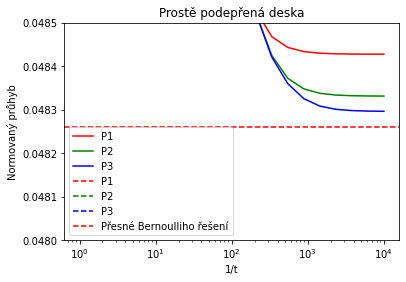

In [3]:
Ei, nui = 1.0, 0.1

ts = np.logspace(-4, 0, num=20)
ws_ql_ss_p1_s = [plate_solver(tsi, Ei, nui, 1, "shear", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]
ws_ql_ss_p2_s = [plate_solver(tsi, Ei, nui, 2, "shear", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]
ws_ql_ss_p3_s = [plate_solver(tsi, Ei, nui, 3, "shear", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]

ws_ql_ss_p1_a = [plate_solver(tsi, Ei, nui, 1, "all", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]
ws_ql_ss_p2_a = [plate_solver(tsi, Ei, nui, 2, "all", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]
ws_ql_ss_p3_a = [plate_solver(tsi, Ei, nui, 3, "all", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]

plt.title("Prostě podepřená deska")
plt.plot(1 / ts, ws_ql_ss_p1_s, color="r", label="P1")
plt.plot(1 / ts, ws_ql_ss_p2_s, color="g", label="P2")
plt.plot(1 / ts, ws_ql_ss_p3_s, color="b", label="P3")
plt.plot(1 / ts, ws_ql_ss_p1_a, "--", color="r", label="P1")
plt.plot(1 / ts, ws_ql_ss_p2_a, "--", color="g", label="P2")
plt.plot(1 / ts, ws_ql_ss_p3_a, "--", color="b", label="P3")
plt.axhline(y=0.004062353*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.048, 0.0485)
plt.legend()
plt.show()

In [ ]:
Ei, nui = 1.0, 0.1

ts = np.logspace(-4, 0, num=20)
ws_ql_ss_p1 = [plate_solver(tsi, Ei, nui, 1, "shear", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]
ws_ql_ss_p2 = [plate_solver(tsi, Ei, nui, 2, "shear", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]
ws_ql_ss_p3 = [plate_solver(tsi, Ei, nui, 3, "shear", dolfinx.mesh.CellType.quadrilateral, "P", False, 10) for tsi in ts]

ws_ql_ff_p1 = [plate_solver(tsi, Ei, nui, 1, "shear", dolfinx.mesh.CellType.quadrilateral, "P", True, 10) for tsi in ts]
ws_ql_ff_p2 = [plate_solver(tsi, Ei, nui, 2, "shear", dolfinx.mesh.CellType.quadrilateral, "P", True, 10) for tsi in ts]
ws_ql_ff_p3 = [plate_solver(tsi, Ei, nui, 3, "shear", dolfinx.mesh.CellType.quadrilateral, "P", True, 10) for tsi in ts]

plt.title("Prostě podepřená deska")
plt.plot(1 / ts, ws_ql_ss_p1, color="r", label="P1")
plt.plot(1 / ts, ws_ql_ss_p2, color="g", label="P2")
plt.plot(1 / ts, ws_ql_ss_p3, color="b", label="P3")
plt.axhline(y=0.004062353*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
plt.ylim(0.048, 0.05)
plt.legend()
plt.show()

plt.title("Po obvodě vetknutá deska")
plt.plot(1 / ts, ws_ql_ff_p1, color="r", label="P1")
plt.plot(1 / ts, ws_ql_ff_p2, color="g", label="P2")
#plt.plot(1 / ts, ws_ql_ff_p3, color="b", label="P3")
plt.axhline(y=0.001265319*12*(1-nui**2)/Ei, color="r", linestyle="--", label="Přesné Bernoulliho řešení")
plt.xlabel("1/t")
plt.ylabel("Normovaný průhyb")
plt.semilogx()
#plt.ylim(0.0145, 0.0155)
plt.legend()
plt.show()